In [1]:
%pylab notebook

# Run on CPU not GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
from tensorflow.keras import layers

from primo.models.cas9_keras import log10_crispr_spec

import primo.models
import primo.datasets
import primo.tools.filepath as filepaths
import primo.tools.sequences as seqtools
import pandas as pd


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-6t26eb00 because the default path (/tf/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Populating the interactive namespace from numpy and matplotlib


In [11]:
### 
# Load the model to be examined
encoder = primo.models.Encoder('/tf/primo/data/models/encoder_2site_triplet_20210131_1.h5')
###

### 
# Define utilities
###
def make_multisite_predictor(predictor):
    """Return a function that will predict multiple sites using the predictor
    function provided to score each
    
    Combined probability is 1 - (1 - P(site1)) * (1 - P(site2)) ... * (1 - P(siteN))
    """
    def multisite_predict(seq_pairs):
        n_sites = int(seq_pairs.shape[2] / 20)
        # Split into separate sites
        sites = tf.stack(tf.split(seq_pairs, n_sites, axis=2))
        # Apply predictor to sites independently
        scores = tf.map_fn(tf.function(predictor), sites)
        #scores *= tf.sqrt(tf.reduce_mean(tf.reduce_max(seq_pairs, axis=-1)))
        # Compute combined probability|
        #return tf.reduce_max(scores, axis=0)
        #return 2 * (tf.sigmoid(3*tf.sqrt(tf.reduce_sum(scores, axis=0))) - 0.5)
        return 1 - tf.reduce_prod(1 - scores, axis=0)
    return multisite_predict

def log_multisite_predictor(seq_pairs):
    n_sites = int(seq_pairs.shape[2] / 20)
    # Split into separate sites
    sites = tf.stack(tf.split(seq_pairs, n_sites, axis=2))
    # Apply predictor to sites independently
    scores = tf.map_fn(tf.function(log10_crispr_spec), sites)
    linear_scores = 10**scores
    return tf.experimental.numpy.log10(tf.reduce_sum(linear_scores, axis=0))

def confidence_by_base(sequences):
    """Takes a batch of softmax sequences, and returns vector of average confidence in each position
    
    sequences: Number of exmaple x Number of bases x 4
    
    Returns: 1 x number of bases
    """
    # reduce last dimension to max base number
    return np.mean(np.max(sequences, axis=-1), axis=0)

def entropy_by_base(sequences):
    x = np.sum(sequences, axis=0)
    x /= np.sum(x, axis=1)[:, None]
    entropy = -np.sum(x * np.log(x + 1e-10), axis=1)
    return entropy

def base_distribution(sequences):
    one_hots = one_hot(sequences)
    bases = np.sum(one_hots, axis=0)

def one_hot(nparray, depth = 0, on_value = 1, off_value = 0):
    if depth == 0:
        depth = np.max(nparray) + 1
    assert np.max(nparray) < depth, "the max index of nparray: {} is larger than depth: {}".format(np.max(nparray), depth)
    shape = nparray.shape
    out = np.ones((*shape, depth), dtype=np.float32) * off_value
    indices = []
    for i in range(nparray.ndim):
        tiles = [1] * nparray.ndim
        s = [1] * nparray.ndim
        s[i] = -1
        r = np.arange(shape[i]).reshape(s)
        if i > 0:
            tiles[i-1] = shape[i-1]
            r = np.tile(r, tiles)
        indices.append(r)
    indices.append(nparray)
    out[tuple(indices)] = on_value
    return out

def get_multiple_batchs(n, generator):
    indices = None
    values = None
    for _ in range(n):
        i, v = next(generator)
        if indices is None:
            indices = i
            values = v
        else:
            indices = np.concatenate([indices, i])
            values = np.concatenate([values, v])
    return indices, values

encoder.model.compile()


In [ ]:
###
# Load queries and see what they encode to
###
query_features_filepath = filepaths.get_query_features_path(isDocker=True)
query_features = pd.read_hdf(query_features_filepath)
query_seqs = encoder.encode_feature_seqs(query_features)
print(f"Query Seqs: \n" + "\n".join(query_seqs))

def seq_str_to_input(seq):
    return np.transpose(seqtools.seqs_to_onehots(seq), [1, 0, 2])


In [4]:
###
# Use data batch generators to get a batch of random training and validation
# data
###encoder_1site_triplet_20220128_1

def keras_batch_generator(dataset_batch_generator, similarity_threshold):
    # Yield datasets
    # TODO: Verify with Callie this understanding is correct https://github.com/uwmisl/cas9-similarity-search/issues/2
    while True:
        # This tuple contains:
        # indices: a positive integer uniquely identifying an image. This index is obtained by enumerating all the images in the dataset (before splitting them into test/train/validate datasets)
        # pairs:
        indices, pairs = next(dataset_batch_generator)
        # The Euclidean distances between the two vectors in each pair
        distances = np.sqrt(np.square(pairs[:,0,:] - pairs[:,1,:]).sum(1))
        # Whether or not the images in this pair should be considered 'similar'. This is a boolean value, represented by an int (0 or 1), and is determined by whether the aforementioned Euclidean distances between image feature vectors are under some pre-deterined "similarity threshold".
        similar = (distances < similarity_threshold).astype(int)
        # Yield a pair of sequences, and 0-or-1 indicating whether they're similar.
        yield pairs, similar

batch_size = 200
similarity_threshold = 75
train_dataset = primo.datasets.OpenImagesTrain(
    '/tf/open_images/train/', switch_every=10**5
)
validation_dataset = primo.datasets.OpenImagesVal('/tf/open_images/validation/')
 
# Generator for triplets
train_triplet_generator = primo.datasets.dataset.triplet_batch_generator(
    train_dataset.random_features(batch_size),
    similarity_threshold
)

val_triplet_generator = primo.datasets.dataset.triplet_batch_generator(
    validation_dataset.random_features(batch_size),
    similarity_threshold
)

# Generators for balanced pairs
train_pair_generator = keras_batch_generator(
    train_dataset.balanced_pairs(batch_size, similarity_threshold),
    similarity_threshold
)
val_pair_generator = keras_batch_generator(
    validation_dataset.balanced_pairs(batch_size, similarity_threshold),
    similarity_threshold
)

# batch = next(batch_generator)
# del batch_generator

# val_batch = next(encoder_val_batches)
# del encoder_val_batches

recall: 0.85, false_positive: 0.47


<IPython.core.display.Javascript object>


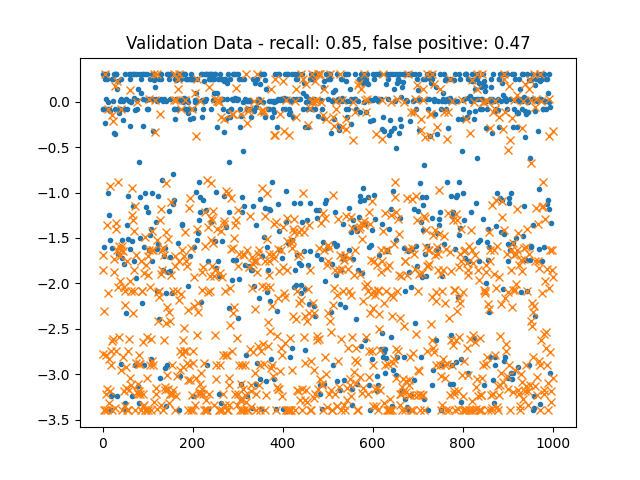

recall: 0.82, false_positive: 0.47


<IPython.core.display.Javascript object>


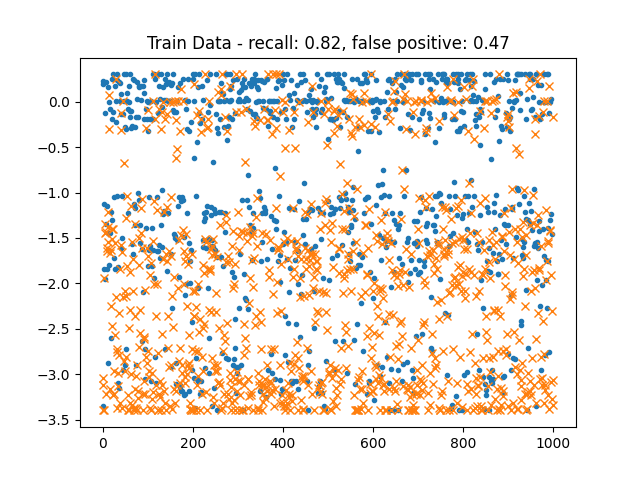

In [13]:
def plot_pair_scatter(seq_pairs, y_true, title):
    pairs_p = seq_pairs[y_true > 0.5]
    pairs_n = seq_pairs[y_true < 0.5]
    # Compute the log10 scores for positive (similar) pairs
    Yp = log_multisite_predictor(pairs_p).numpy()
    # Compute the log10 score for negative (dis-similar) pairs
    Yn = log_multisite_predictor(pairs_n).numpy()

    recall = (Yp > -2.0).mean()
    false_positive = (Yn > -2.0).mean()
    print(f"recall: {recall:.2f}, false_positive: {false_positive:.2f}")

    plt.figure()
    plt.plot(Yp, '.', label='pos')
    plt.plot(Yn, 'x', label='neg')
    plt.title(f'{title} - recall: {recall:0.2f}, false positive: {false_positive:0.2f}')

val_feat_pairs, val_truth = get_multiple_batchs(10, val_pair_generator)
val_seq_pairs = one_hot(np.stack([
    encoder.model.predict(val_feat_pairs[:, 0, :]).argmax(-1),
    encoder.model.predict(val_feat_pairs[:, 1, :]).argmax(-1),
], axis=1)).astype(np.float32)

train_feat_pairs, train_truth = get_multiple_batchs(10, train_pair_generator)
train_seq_pairs = one_hot(np.stack([
    encoder.model.predict(train_feat_pairs[:, 0, :]),
    encoder.model.predict(train_feat_pairs[:, 1, :]),
], axis=1).argmax(-1))

plot_pair_scatter(val_seq_pairs, val_truth, 'Validation Data')
plot_pair_scatter(train_seq_pairs, train_truth, 'Train Data')

<IPython.core.display.Javascript object>


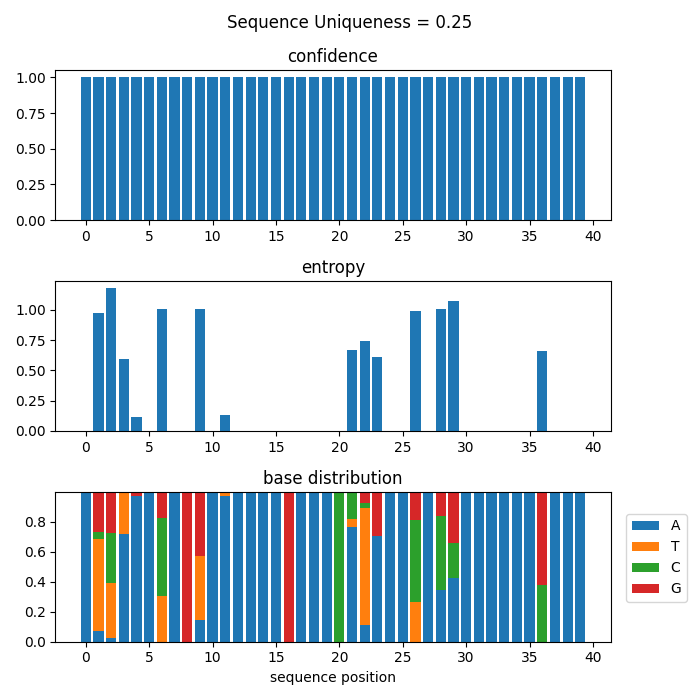

In [14]:
### Sequence Confidence and Variation
#
# Get a random set of validation features and encode to sequences, then 
# plot the confidence and variation (entropy) of the sequence pool
# for each sequence position. 

_, example_features = next(validation_dataset.random_features(500))
seqs_softmax = encoder.model.predict(example_features)
seqs_onehot = one_hot(seqs_softmax.argmax(-1))

unique_seqs = np.unique(seqs_onehot, axis=0)
sequence_uniqueness = len(unique_seqs) / len(seqs_onehot)

base_distributions = seqs_onehot.sum(0) / len(seqs_onehot)
seqlen = seqs_onehot.shape[1]

confidence = confidence_by_base(seqs_softmax)
entropy = entropy_by_base(seqs_softmax)

seqlen = seqs_softmax.shape[1]
fig = plt.figure(figsize=[7, 7])
fig.suptitle(f'Sequence Uniqueness = {sequence_uniqueness:0.2f}')
axes = fig.subplots(3,1)

ax = axes[0]
ax.bar(np.arange(0, seqlen), confidence)
ax.set_title('confidence')

ax = axes[1]
ax.bar(np.arange(0, seqlen), entropy)
ax.set_title('entropy')

ax = axes[2]
ax.set_title('base distribution')
ax.set_xlabel('sequence position')
bottom = np.zeros_like(base_distributions[:, 0])
ax.bar(np.arange(seqlen), base_distributions[:, 0], label='A', )
bottom += base_distributions[:, 0]
ax.bar(np.arange(seqlen), base_distributions[:, 1], label='T', bottom=bottom)
bottom += base_distributions[:, 1]
ax.bar(np.arange(seqlen), base_distributions[:, 2], label='C', bottom=bottom)
bottom += base_distributions[:, 2]
ax.bar(np.arange(seqlen), base_distributions[:, 3], label='G', bottom=bottom)
ax.legend(bbox_to_anchor=(1.15, 0.9))

plt.tight_layout()

In [7]:
seqs_softmax

array([[[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        ...,
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.]],

       [[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        ...,
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.]],

       [[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        ...,
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.]],

       ...,

       [[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.]],

       [[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.]],

       [[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        ...,
        [0., 0., 1., 0.],
        [0., 0.

In [8]:
### Plot random batch using triplet generator
#
# This suffers from the problem of anchors without positive pairs. 
# For some percentage of anchors, a positive pair cannot be found
# so they are returned with themselves as their positive pairing. 
# Validation data has about twice the rate of self-pairing as
# training data, and it is significant; about 18% and 9% for val
# and train respectively. These positives are recalled basically 
# "for free" and bias the results. 
# For this reason, triplet generators shouldn't be used for scoring
# the model.

# 
# def plot_triplet_scatter(triplet_seqs, title):
#     # Compute the log10 scores for positive (similar) pairs
#     Yp = log_multisite_predictor(tf.gather(triplet_seqs, [0, 1], axis=1)).numpy()
#     # Compute the log10 score for negative (dis-similar) pairs
#     Yn = log_multisite_predictor(tf.gather(triplet_seqs, [0, 2], axis=1)).numpy()

#     recall = (Yp > -2.0).mean()
#     false_positive = (Yn > -2.0).mean()
#     print(f"recall: {recall:.2f}, false_positive: {false_positive:.2f}")

#     plt.figure()
#     plt.plot(Yn, 'o', label='pos')
#     plt.plot(Yp, 'x', label='neg')
#     plt.title(f'{title} - recall: {recall:0.2f}, false positive: {false_positive:0.2f}')

# _, val_triplets = get_multiple_batchs(3, val_triplet_generator)
# val_triplet_seqs = np.stack([
#     encoder.model.predict(val_triplets[:, 0, :]),
#     encoder.model.predict(val_triplets[:, 1, :]),
#     encoder.model.predict(val_triplets[:, 2, :]),
# ], axis=1)

# _, train_triplets = get_multiple_batchs(3, train_triplet_generator)
# train_triplet_seqs = np.stack([
#     encoder.model.predict(train_triplets[:, 0, :]),
#     encoder.model.predict(train_triplets[:, 1, :]),
#     encoder.model.predict(train_triplets[:, 2, :]),
# ], axis=1)

# plot_triplet_scatter(val_triplet_seqs, 'Validation Data')
# plot_triplet_scatter(train_triplet_seqs, 'Train Data')





In [9]:
# first_time_point = 12
# last_time_point = 60000
# first_time_point_cleavage_rate = np.log(2)/first_time_point
# last_time_point_cleavage_rate = np.log(2)/last_time_point
# log10_ub = np.log10(first_time_point_cleavage_rate).astype(np.float32)
# log10_lb = np.log10(last_time_point_cleavage_rate).astype(np.float32)

# def plot(scores, y_true, title):
#     #log10_scores = 1 + (log10(scores+1e-12)) / (log10_ub - log10_lb)
#     log10_scores = log10(scores+1e-12)
#     true_idx = y_true > 0.5;
#     false_idx = y_true  <= 0.5;
#     plt.figure()
#     plt.subplot(2,2,1);
#     plt.suptitle(title)
#     plt.hist(scores[true_idx]);
#     plt.title('similar')
#     plt.xlabel('linear cut rate')
#     plt.xlim([0, 1.0])
#     plt.subplot(2,2,3)
#     plt.hist(scores[false_idx]);
#     plt.title('dissimilar')
#     plt.xlabel('linear cut rate')
#     plt.xlim([0, 1.0])
#     plt.subplot(2,2,2);
#     plt.hist(log10_scores[true_idx]);
#     plt.title('similar')
#     plt.xlabel('normalized log10 cut rate')
#     plt.xlim([-3.7, 0.0])
#     plt.subplot(2,2,4);
#     plt.hist(log10_scores[false_idx]);
#     plt.title('dissimilar')
#     plt.xlabel('normalized log10 cut rate')
#     plt.xlim([-3.7, 0.0])
#     plt.tight_layout()
    

# seqs_softmax = encoder_trainer.calcseq.predict(batch[0])
# primary_seqs = seqtools.onehots_to_seqs(seqs_softmax[:, 0, :, :])
# secondary_seqs = seqtools.onehots_to_seqs(seqs_softmax[:, 1, :, :])
# p_unique_count = len(np.unique(primary_seqs))
# s_unique_count = len(np.unique(secondary_seqs))
# print(f"Unique: {p_unique_count} / {len(primary_seqs)}")
# print(f"Unique: {s_unique_count} / {len(secondary_seqs)}")

# simulator = primo.models.Simulator()

# if (len(primary_seqs) % 20) != 0:
#     raise ValueError("Sequence length must be multiple of 20 ")

# sites = int(len(primary_seqs[0]) / 20)

# site_scores = np.array([
#     simulator.simulate(pd.DataFrame({
#         'query_features': [s[i*20:(i+1)*20] for s in primary_seqs],
#         'target_features': [s[i*20:(i+1)*20] for s in secondary_seqs],
#     })) for i in range(sites) ])

# print(site_scores.shape)
# #sim_scores = 1 - np.prod(1 - site_scores, axis=0)
# sim_scores = np.max(site_scores, axis=0)
# print(sim_scores.shape)

# model_scores = encoder_trainer.model.predict(batch[0])
# print(f"model scores: {model_scores.min()} - {model_scores.max()}")
# # # Undo the model output power
# model_scores = 10**model_scores

# #plot(model_scores, batch[1], 'Training data - model scores')
# plot(sim_scores, batch[1], 'Training data - sim scores')





In [10]:
os.getcwd()

'/tf/primo/notebooks/00_prototypes'